<a href="https://colab.research.google.com/github/Yuji-github/Medical_ML_DL/blob/main/Medical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Import dataset

In [ ]:
df = pd.read_csv('Medicalpremium.csv')
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


# Preprocessing

0 is No, 1 is Yes

In [ ]:
df.info()

No missing values

In [ ]:
df.describe()

Check Correlations 

In [ ]:
corr = df.corrwith(df.iloc[:, -1], axis=0).drop(labels=['PremiumPrice'])

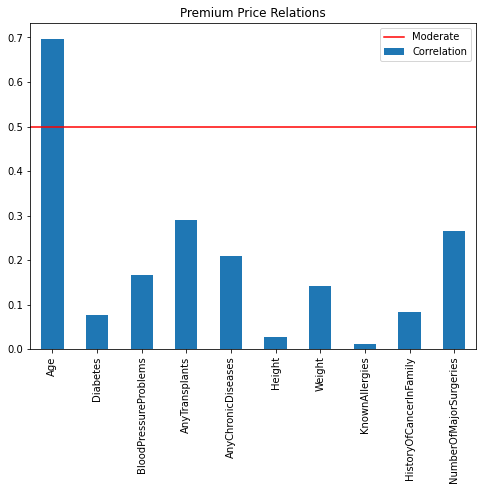

In [ ]:
plt.figure(figsize=(8, 6))
plt.axhline(y=0.5, color='r', linestyle='-', label='Moderate') # modelate line 
corr.plot(kind='bar', label='Correlation')
plt.legend()
plt.title("Premium Price Relations")
plt.show()

Age is related (strongly positive) to the price. -> Older more expensive

In [ ]:
print("Avg Price '18-30', '30-42', '42-54', '54-66' \n", 
      df[['PremiumPrice']] [(df["Age"] >= 18) & (df["Age"] <= 30)].mean(), 
      df[['PremiumPrice']] [(df["Age"] > 30) & (df["Age"] <= 42)].mean(), 
      df[['PremiumPrice']] [(df["Age"] > 42) & (df["Age"] <= 54)].mean(), 
      df[['PremiumPrice']] [(df["Age"] > 54) & (df["Age"] <= 66)].mean()
      )

Avg Price '18-30', '30-42', '42-54', '54-66' 
 PremiumPrice    17057.471264
dtype: float64 PremiumPrice    24836.134454
dtype: float64 PremiumPrice    27318.35206
dtype: float64 PremiumPrice    28813.636364
dtype: float64


In [ ]:
pd.cut(df['Age'], bins=4).value_counts()

No imbalanced datasets by Age

Age Base Analysis

In [ ]:
young = df[(df["Age"] >= 18) & (df["Age"] <= 30)]
adult1 = df[(df["Age"] > 30) & (df["Age"] <= 42)]
adult2 = df[(df["Age"] > 42) & (df["Age"] <= 54)]
senior = df[(df["Age"] > 54) & (df["Age"] <= 66)]

In [ ]:
y_corr = young.corrwith(young.iloc[:, -1], axis=0).drop(labels=['PremiumPrice'])
a1_corr = adult1.corrwith(adult1.iloc[:, -1], axis=0).drop(labels=['PremiumPrice'])
a2_corr = adult2.corrwith(adult2.iloc[:, -1], axis=0).drop(labels=['PremiumPrice'])
s_corr = senior.corrwith(senior.iloc[:, -1], axis=0).drop(labels=['PremiumPrice'])

g = ['18-30', '30-42', '42-54', '54-66'] # for plotting and models later

In [ ]:
age_base = pd.DataFrame([y_corr, a1_corr, a2_corr, s_corr])
age_base

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries
0,0.279483,-0.025038,0.210001,0.190133,0.392123,-0.034182,0.089217,-0.027177,-0.002234,0.022974
1,0.168016,-0.068791,-0.016865,0.701766,0.185736,0.006177,0.100211,0.102118,0.360884,0.180751
2,0.279309,-0.030344,-0.025848,0.457739,0.187229,0.009577,0.372832,0.035739,0.188840,0.153886
3,0.038370,-0.144390,-0.104692,0.444280,0.101037,0.022144,0.471978,0.030195,0.086653,-0.132850


In [ ]:
pos = 1

for itr in age_base:
  plt.subplot(5, 2, pos)

  plt.subplots_adjust(left=1, right=2.5, top=4) # adjusting subplot

  sns.barplot(x=g, y=itr, data=age_base)
  plt.axhline(y=0.5, color='r', linestyle='-', label='Moderate') # most of them is positive, -> no strongly negative (-0.5 [Moderate])
  pos +=1

plt.show()

Between 30 and 42 years, "AnyTransplants" is most related.

In [ ]:
df.boxplot(["Height", "Weight"])

Some of people are over 100 kg -> Diabetes?

In [ ]:
count = 0
overweight = 0 
index = []

for itr, weight in enumerate(df["Weight"]): 
  if weight > 100: # almost 2 SD different 

    overweight +=1

    if df.loc[itr, 'Diabetes'] == 1: # yes, diabetes
      count +=1
      index.append(itr)

print("related to weight and diabetes is %.2f percent" %(count/overweight) )

related to weight and diabetes is 0.36 percent


In [ ]:
print("Avg Price Diabetes, Non-Diabetes, and OverWeight(Diabetes) \n", 
      df[['Diabetes', 'PremiumPrice']] [df['Diabetes'] == 1].mean(), 
      df[['Diabetes', 'PremiumPrice']] [df['Diabetes'] == 0].mean(), 
      df[['Diabetes', 'PremiumPrice']] [(df['Diabetes'] == 1) & (df['Weight'] > 100)].mean(), 
      )

Avg Price Diabetes, Non-Diabetes, and OverWeight(Diabetes) 
 Diabetes            1.000000
PremiumPrice    24896.135266
dtype: float64 Diabetes            0.000000
PremiumPrice    23931.818182
dtype: float64 Diabetes            1.000000
PremiumPrice    28714.285714
dtype: float64


Overweight and Diabetes people are higher than the average (as the same as 54+) 

# Regression Models

In [ ]:
from sklearn.model_selection import train_test_split
# independent variable
x = df.iloc[:, 1:-1].values

# dependent variable
y = df.iloc[:, -1].values

In [ ]:
# splitting into 4 parts, but it is too small
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor # for random forest regression
rfr_reg = RandomForestRegressor(n_estimators=1000, random_state=0) # number of trees (default is 100)
rfr_reg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

# Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error
print("Premium Price Estimation Difference is $%.2f" %mean_absolute_error(y_test, rfr_reg.predict(x_test)))
ev1 = mean_absolute_error(y_test, rfr_reg.predict(x_test))

Premium Price Estimation Difference is $4559.60


# Round 2 

Select Top 5 Related Features 

In [ ]:
corr.sort_values(ascending=False)

Age                        0.697540
AnyTransplants             0.289056
NumberOfMajorSurgeries     0.264250
AnyChronicDiseases         0.208610
BloodPressureProblems      0.167097
Weight                     0.141507
HistoryOfCancerInFamily    0.083139
Diabetes                   0.076209
Height                     0.026910
KnownAllergies             0.012103
dtype: float64

In [ ]:
top5 = ['Age', 'AnyTransplants', 'NumberOfMajorSurgeries', 'BloodPressureProblems', 'Weight']
top_x = df.loc[:, top5].values

In [ ]:
top_x_train, top_x_test, top_y_train, top_y_test = train_test_split(top_x, y, train_size=0.9, random_state=1)

sc = StandardScaler()
top_x_train = sc.fit_transform(top_x_train)
top_x_test = sc.transform(top_x_test)

In [ ]:
top_rfr_reg = RandomForestRegressor(n_estimators=1000, random_state=0) # number of trees (default is 100)
top_rfr_reg.fit(top_x_train, top_y_train)

print("Premium Price Estimation Difference is $%.2f" %mean_absolute_error(top_y_test, top_rfr_reg.predict(top_x_test)))
ev2 = mean_absolute_error(top_y_test, top_rfr_reg.predict(top_x_test))

Premium Price Estimation Difference is $1606.05


# Round 3 Age Base [Top 5 features]

Between 18 and 30

In [ ]:
y_corr.sort_values(ascending=False)

AnyChronicDiseases         0.392123
Age                        0.279483
BloodPressureProblems      0.210001
AnyTransplants             0.190133
Weight                     0.089217
NumberOfMajorSurgeries     0.022974
HistoryOfCancerInFamily   -0.002234
Diabetes                  -0.025038
KnownAllergies            -0.027177
Height                    -0.034182
dtype: float64

In [ ]:
y_top5 = ['Age', 'AnyTransplants', 'NumberOfMajorSurgeries', 'BloodPressureProblems', 'Weight']

y_top_x = young.loc[:, y_top5].values
y_y = young.iloc[:, -1].values

y_x_train, y_x_test, y_y_train, y_y_test = train_test_split(y_top_x, y_y, train_size=0.9, random_state=1)

sc = StandardScaler()
y_x_train = sc.fit_transform(y_x_train)
y_x_test = sc.transform(y_x_test)

y_rfr_reg = RandomForestRegressor(n_estimators=100, random_state=0) # number of trees (default is 100)
y_rfr_reg.fit(y_x_train, y_y_train)

print("Premium Price Estimation Difference is $%.2f" %mean_absolute_error(y_y_test, y_rfr_reg.predict(y_x_test)))

res_y = mean_absolute_error(y_y_test, y_rfr_reg.predict(y_x_test))

Premium Price Estimation Difference is $900.37


Between 30 and 42

In [ ]:
a1_corr.sort_values(ascending=False)

AnyTransplants             0.701766
HistoryOfCancerInFamily    0.360884
AnyChronicDiseases         0.185736
NumberOfMajorSurgeries     0.180751
Age                        0.168016
KnownAllergies             0.102118
Weight                     0.100211
Height                     0.006177
BloodPressureProblems     -0.016865
Diabetes                  -0.068791
dtype: float64

In [ ]:
a1_top5 = ['Age', 'AnyChronicDiseases', 'NumberOfMajorSurgeries', 'HistoryOfCancerInFamily', 'AnyTransplants']

a1_top_x = adult1.loc[:, a1_top5].values
a1_y = adult1.iloc[:, -1].values

a1_x_train, a1_x_test, a1_y_train, a1_y_test = train_test_split(a1_top_x, a1_y, train_size=0.9, random_state=1)

sc = StandardScaler()
a1_x_train = sc.fit_transform(a1_x_train)
a1_x_test = sc.transform(a1_x_test)

a1_rfr_reg = RandomForestRegressor(n_estimators=10, random_state=0) # number of trees (default is 100)
a1_rfr_reg.fit(a1_x_train, a1_y_train)

print("Premium Price Estimation Difference is $%.2f" %mean_absolute_error(a1_y_test, a1_rfr_reg.predict(a1_x_test)))

res_a1 = mean_absolute_error(a1_y_test, a1_rfr_reg.predict(a1_x_test))

Premium Price Estimation Difference is $500.26


Between 42 and 54

In [ ]:
a2_corr.sort_values(ascending=False)

AnyTransplants             0.457739
Weight                     0.372832
Age                        0.279309
HistoryOfCancerInFamily    0.188840
AnyChronicDiseases         0.187229
NumberOfMajorSurgeries     0.153886
KnownAllergies             0.035739
Height                     0.009577
BloodPressureProblems     -0.025848
Diabetes                  -0.030344
dtype: float64

In [ ]:
a2_top5 = ['Age', 'AnyChronicDiseases', 'Weight', 'HistoryOfCancerInFamily', 'AnyTransplants']

a2_top_x = adult2.loc[:, a2_top5].values
a2_y = adult2.iloc[:, -1].values

a2_x_train, a2_x_test, a2_y_train, a2_y_test = train_test_split(a2_top_x, a2_y, train_size=0.9, random_state=1)

sc = StandardScaler()
a2_x_train = sc.fit_transform(a2_x_train)
a2_x_test = sc.transform(a2_x_test)

a2_rfr_reg = RandomForestRegressor(n_estimators=20, random_state=0) # number of trees (default is 100)
a2_rfr_reg.fit(a2_x_train, a2_y_train)

print("Premium Price Estimation Difference is $%.2f" %mean_absolute_error(a2_y_test, a2_rfr_reg.predict(a2_x_test)))

res_a2 = mean_absolute_error(a2_y_test, a2_rfr_reg.predict(a2_x_test))

Premium Price Estimation Difference is $2931.67


Between 54 and 66

In [ ]:
s_corr.sort_values(ascending=False)

Weight                     0.471978
AnyTransplants             0.444280
AnyChronicDiseases         0.101037
HistoryOfCancerInFamily    0.086653
Age                        0.038370
KnownAllergies             0.030195
Height                     0.022144
BloodPressureProblems     -0.104692
NumberOfMajorSurgeries    -0.132850
Diabetes                  -0.144390
dtype: float64

In [ ]:
s_top5 = ['Diabetes', 'BloodPressureProblems', 'Weight', 'NumberOfMajorSurgeries', 'AnyTransplants']

s_top_x = senior.loc[:, s_top5].values
s_y = senior.iloc[:, -1].values

s_x_train, s_x_test, s_y_train, s_y_test = train_test_split(s_top_x, s_y, train_size=0.9, random_state=1)

sc = StandardScaler()
s_x_train = sc.fit_transform(s_x_train)
s_x_test = sc.transform(s_x_test)

s_rfr_reg = RandomForestRegressor(n_estimators=50, random_state=0) # number of trees (default is 100)
s_rfr_reg.fit(s_x_train, s_y_train)

print("Premium Price Estimation Difference is $%.2f" %mean_absolute_error(s_y_test, s_rfr_reg.predict(s_x_test)))

res_s = mean_absolute_error(s_y_test, s_rfr_reg.predict(s_x_test))

Premium Price Estimation Difference is $1091.51


# Evaluation

In [ ]:
ev3 = (res_y + res_a1 + res_a2 + res_s) / 4

print("Round 1:", ev1,  " Round 2:", ev2,  " Round 3:", ev3)

Round 1: 4559.596584896585  Round 2: 1606.050529100529  Round 3: 1355.9509836228588


Age Base is better than other models

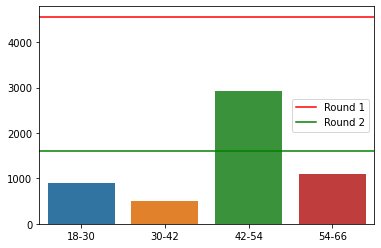

In [ ]:
sns.barplot(x=g, y=[res_y, res_a1, res_a2, res_s])
plt.axhline(y=ev1, color='r', linestyle='-', label='Round 1')
plt.axhline(y=ev2, color='g', linestyle='-', label='Round 2')
plt.legend()

# ANN Model (More Data, Much Better)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPool2D, BatchNormalization, Activation, Add, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# independent variable
ann_x = df.iloc[:, 1:-1].values

# dependent variable
ann_y = df.iloc[:, -1].values

# splitting into 4 parts, but it is too small
ann_x_train, ann_x_test, ann_y_train, ann_y_test = train_test_split(ann_x, ann_y, train_size=0.9, random_state=1)

sc = StandardScaler()
ann_x_train = sc.fit_transform(ann_x_train)
ann_x_test = sc.transform(ann_x_test)

In [ ]:
# initializing ANN

m = tf.keras.Sequential([
    Input(shape=(9, )),                        
    Dense(200, activation = tf.keras.layers.ReLU(negative_slope=1.0)), # ann_x_train include many negative values
    Dense(10, activation = tf.keras.layers.ReLU(negative_slope=1.0)),
    Dense(1)
])

m.compile(loss='mse', optimizer=Adam(learning_rate=0.0005), metrics = ["mae"])

m.summary()

Training

In [ ]:
model = m.fit(ann_x_train, ann_y_train, epochs=300)

# Evaluation

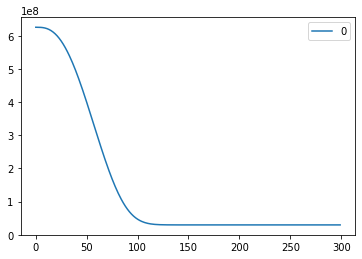

In [ ]:
pd.DataFrame(model.history['loss']).plot()

In [ ]:
print("Round 1:", ev1, " ANN Model:", mean_absolute_error(ann_y_test, m.predict(ann_x_test)))

Round 1: 4559.596584896585  ANN Model: 4541.106100063132


The reason why the values close is the size of the datasets.

DL needs more data for better performances.